# Recurrent w/Attention
---

Before moving on to other architectures, we'll introduce one last concept on RNN's, the concept of **attention**.

One of the main reasons to use attention is the observation that LSTM layers become **less accurate as their length increases**, in NLP applications they loose accuracy when they reach a length of about 20 words and further loose accuracy fairly quickly as their length increases. At around 50 words, performance starts getting fairly poor. Research has show that in NLP applications the performance can be maintained at high levels, beyond a length of 50 words if `attention` is applied to the series of words.

There are a lot of good resources online that go into details on how self-attention works. We'll cover it in extremely broad terms here. Attention is basically a way for the model to 'pay atttention' to the most relevant parts of the series. There's lots of ways to implement attention. In this notebooks we are going to have some fun with a custom 'Fraud' implementation. __It is different to the standard reference__ as described in famed [Attention is all you need paper](https://arxiv.org/abs/1706.03762). We'll use one which is less complex and see how we got on with that.

Our assumption, *(which needs to be validated)*, will be that while looking at a series of transactions some transctions will be less important in assessing the label than others. Up until now we treat all transactions in a series as equal. But we could try and change that, by assinging different weights to each transaction in the series.

We will achieve this by coming up with a vector that contains weights by which we can weigh our series of payments, the 'weight' vector contains one entry per each step in the series, by which the respective payment will be multiplied. The sum of weights in the weight vector add up to **one**

If $T$ is a 2-D Tensor of size (s,f). I.e a **S**eries of transactions each having **F**eatures. Then our weighted series $wT$ will be $wT_{sf} = T_{sf} * W_{s}$. We just multiply each feature at a position in the series with the weight of that series position.

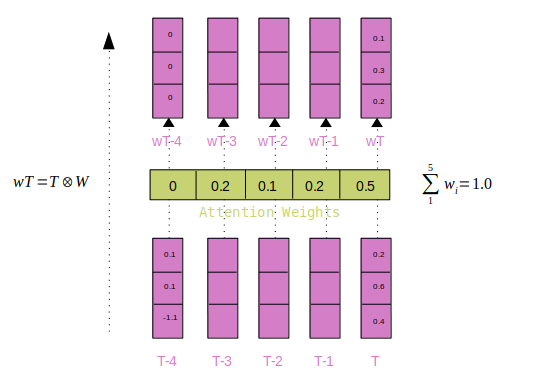

In the example we have 5 transactions. The weights make is so we pay most attention to the last payment, it is multiplied by 0.5. No attention whatsoever is paid to the first payment at T-4, it has 0 as weight.

The million dollar trick is determining the weights; the weights are calculated by taking the dot product of the vector at each time step with the *transpose* of the vector at the last time-step. So $W_{T-i} = T_{T-i} \cdot T^T_{T} $.

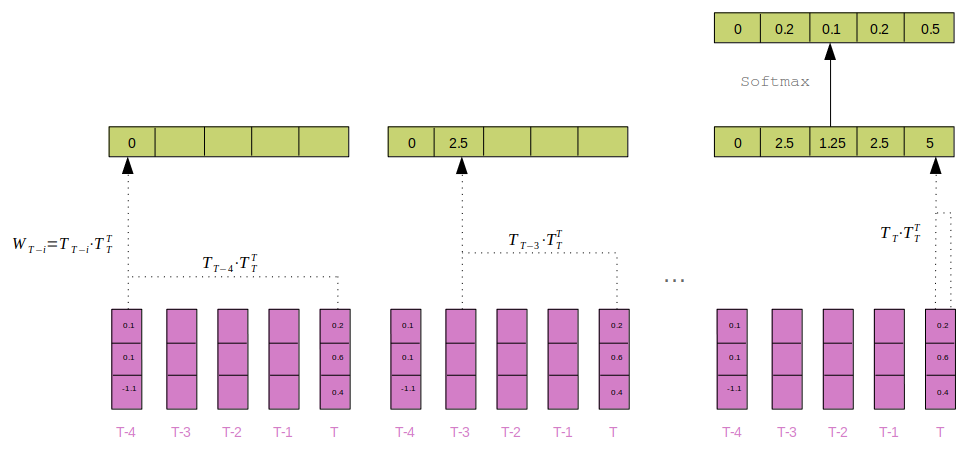

In the attention paper the these vectors are named the __key__ and the __query__. In this implementation the queries are the transactions at each time-step, the key is fixed, it is always the last transaction.

People who are not very familar with machine learning and linear algebra might wonder what the meaning is of $T_{T-i} \cdot T^T_{T}$. What does this say about the 2 payments? From a linear algebra perspective, it means the vectors of these payments point more or less in the same direction. The dot product of 2 vectors is a scalar (a single number). It is basically the cosine of their angle multiplied by their lenghts. $T_{x} \cdot T_{y}^t = \cos\theta \cdot \lvert T_{x} \rvert \cdot \lvert T_{y} \rvert$.

Because of the cosine element, the more the vectors allign and point in the same general direction the more positive the dot product will tend to be. Two vectors that are perpendicular will have 0 as dot product. Beyond that between 90 and 180 degrees the dot product will be negative. It can thus, a bit handwavy, be seen as a **measure of similarity**

The more our payments resemble, the higher our raw weights. We can see that we are likely to pay a lot of  attention to the last payment, the transpose dot product of a vector with itself will have a cosine of 1.

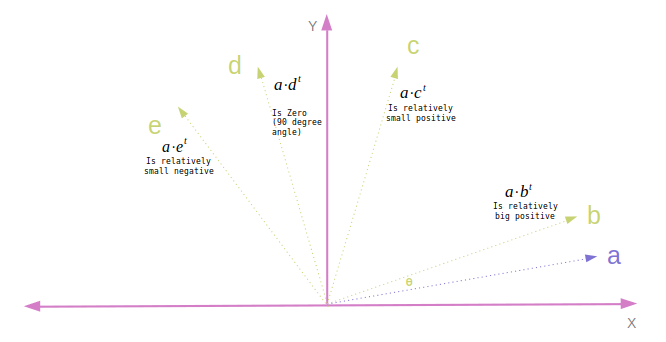



There is one more thing we do, before applying the dot product between **key and query** we apply learnable parameters to them. That means we allow the model to project the key and the query into a new space. The parameters are learnable, implying that the model does not need to use the raw input but it can learn to 'project/transform' the keys and query into a space so their similarity measure can be used to reduce the loss.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import gc
import datetime as dt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../../data/bs140513_032310.csv'

## Define Features

### Define Base Features

In [5]:
# Base Features
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

### Define Derived Features

In [6]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

# Categorical Features
amount_bin   = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_8, amount, 30, scale_type='geometric')
age_i        = ft.FeatureIndex('age_i', ft.FEATURE_TYPE_INT_8, age)
gender_i     = ft.FeatureIndex('gender_i', ft.FEATURE_TYPE_INT_8, gender)
merchant_i   = ft.FeatureIndex('merchant_i', ft.FEATURE_TYPE_INT_8, merchant)
category_i   = ft.FeatureIndex('category_i', ft.FEATURE_TYPE_INT_8, category)

# TimeWaves
waves       = ft.FeatureDateTimeWave('time_waves', ft.FEATURE_TYPE_FLOAT_32, date_time, '%j', int(366/2), 2)

# Label Feature
fraud_label  = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

stacked_ref_series = ft.FeatureSeriesStacked(
    'stacked_ref', ft.FEATURE_TYPE_INT_8, [amount_bin, age_i, gender_i], 5, merchant
)

# TensorDefinition for the stacked wave
stacked_wave_series = ft.FeatureSeriesStacked(
    'stacked_wave', ft.FEATURE_TYPE_FLOAT_32, [waves], 5, merchant
)

td_series_ref  = ft.TensorDefinition('stacked_ref', [stacked_ref_series])
td_series_wv   = ft.TensorDefinition('stacked_wave', [stacked_wave_series])
td_referential = ft.TensorDefinition('referential', [merchant_i, category_i])
td_label       = ft.TensorDefinition('label', [fraud_label])

with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_series_ref, td_series_wv, td_referential, td_label), file, time_feature=date_time, inference=False)

2023-06-25 13:57:42.822 eng1n3.common.engine           INFO     Start Engine...
2023-06-25 13:57:42.822 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-25 13:57:42.823 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-25 13:57:42.823 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../../data/bs140513_032310.csv
2023-06-25 13:57:47.594 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-25 13:57:47.604 e...ureseriesstackedprocessor  INFO     Start creating stacked series for Target Tensor Definitionstacked_ref using 1 process(es)
2023-06-25 13:57:47.714 e...ureseriesstackedprocessor  INFO     Returning series of type int8.
2023-06-25 13:57:47.715 e...ureseriesstackedprocessor  INFO     Series Shape=[(-1, 5, 3)]
2023-06-25 13:57:47.715 e...ureseriesstackedprocessor  INFO     Start creating stacked series for Target Tensor Definitionstacked_wave using 1 process(es)
2023-06-25 13

In [8]:
ti

TensorInstance with shapes: ((594643, 5, 3), (594643, 5, 4), (594643, 2), (594643, 1))

## Create Data-Sets and Loaders

In [9]:
train, val, test = ti.split_sequential(30000, 100000)

batch_size = 128
# Creating DataSets
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

# Creating an oversampler for the training set.
train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

# Setting up the Dataloaders.
train_dl = train_ds.data_loader(data_device, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(data_device, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(data_device, batch_size, num_workers=2)

print(train.shapes)
print(val.shapes)
print(test.shapes)

((464643, 5, 3), (464643, 5, 4), (464643, 2), (464643, 1))
((30000, 5, 3), (30000, 5, 4), (30000, 2), (30000, 1))
((100000, 5, 3), (100000, 5, 4), (100000, 2), (100000, 1))


## Create LSTM Model

The attenion layer is inserted right before the LSTM, we want the attention to be applied before it goes into the LSTM.

In [11]:
class BankSimLSTM(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(BankSimLSTM, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        
        lstm_size = 8 
        # Add attention layer, with a hidden (projection size of 16)
        self.attention = mp.AttentionLastEntry(self.heads[0].output_size+self.heads[1].output_size, 16)        
        self.lstm = nn.LSTM(self.attention.output_size, lstm_size, batch_first=True)
        
        # Set of layers
        self.layers = mp.LinLayer(
            input_size=self.heads[2].output_size+lstm_size, layer_sizes=((16,8)), dropout=0.0, bn_interval=2
        )       

        # And a tail layer. For a binary classifier this adds a linear layer to output a size of 1 + Sigmoid
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # Run heads logic
        h0 = self.heads[0](x[0])
        h1 = self.heads[1](x[1])
        h2 = self.heads[2](x[2])
        # Pass head 0 and 1 (the series) through the attention and LSTM. Concatenate them first.
        h_l = torch.cat((h0, h1), dim=2)
        o = self.attention(h_l)
        o, _ = self.lstm(o)
        # Take the final output
        o = o[:, -1, :]
        # Concatenate to head 2.
        o = torch.cat((h2, o), dim=1)
        # Run through linear layers.
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

#Create a model instance
model = BankSimLSTM(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

BankSimLSTM(
  Number of parameters : 4980. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=SeriesTD, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(9, 5)
          (2): Embedding(5, 5)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(Name=SeriesTD, lc=Continuous)
    (2): TensorDefinitionHead(
      Name=referential, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(51, 25)
          (1): Embedding(16, 8)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (attention): AttentionLastEntry(heads=1, hidden_size=16)
  (lstm): LSTM(16, 8, batch_first=True)
  (layers): LinLayer(
    (layers): Sequential(
      (lin_layer_01): Linear(in_features=41, out_features=16, bias=True)
      (lin_act_01): ReLU()
      (lin_layer_0

## Train

Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 257.43it/s]                                                    


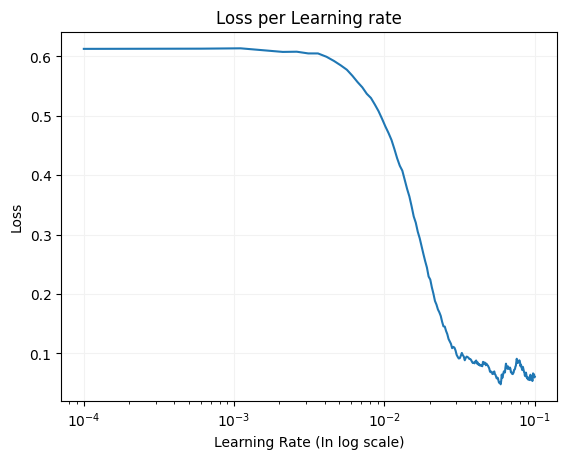

In [13]:
min_lr = 1e-4
max_lr = 1e-1
m_lr = BankSimLSTM(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, model_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);
del m_lr, o_lr, t_lr, lrs
_ = gc.collect()

In [14]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=1e-2)
# Set up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer for [EPOCH] epochs
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 3866/3866 [00:09<00:00, 419.88it/s, t_loss=0.0473, t_acc=0.983, v_loss=0.0398, v_acc=0.98]     


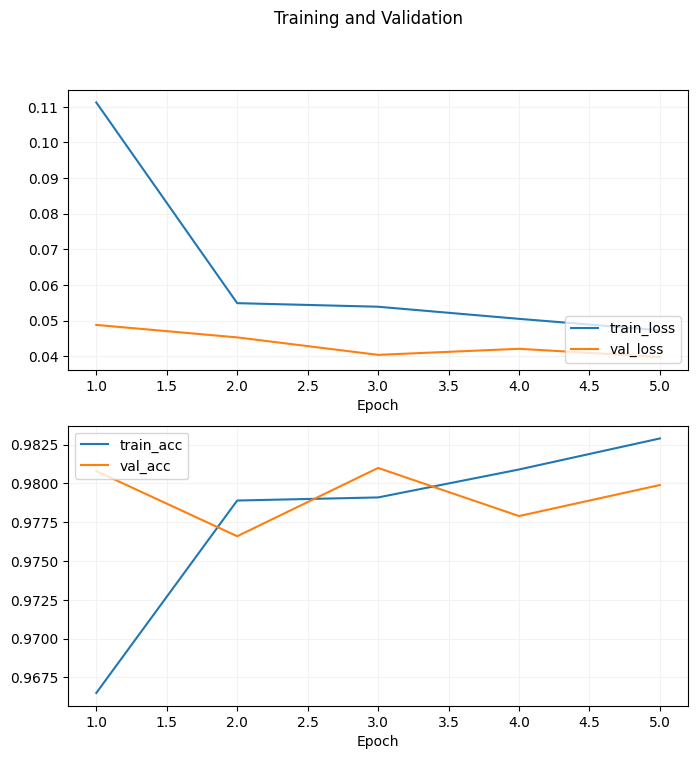

In [15]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

## Test

Testing in 782 steps: 100%|██████████████████| 782/782 [00:00<00:00, 968.33it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     98926
         1.0       0.43      0.97      0.59      1074

    accuracy                           0.99    100000
   macro avg       0.71      0.98      0.79    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9986
ap score  : 0.9210
-----------------------------------------------------


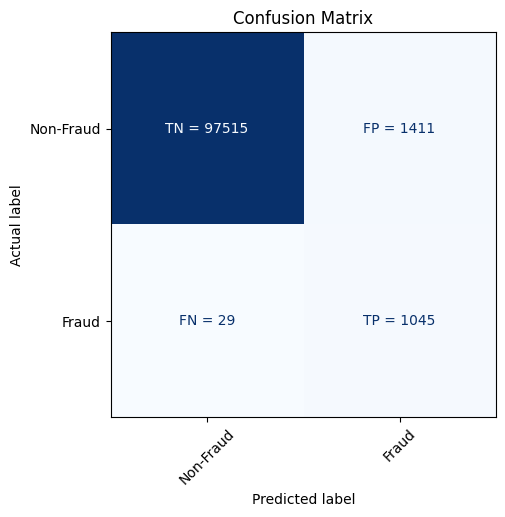

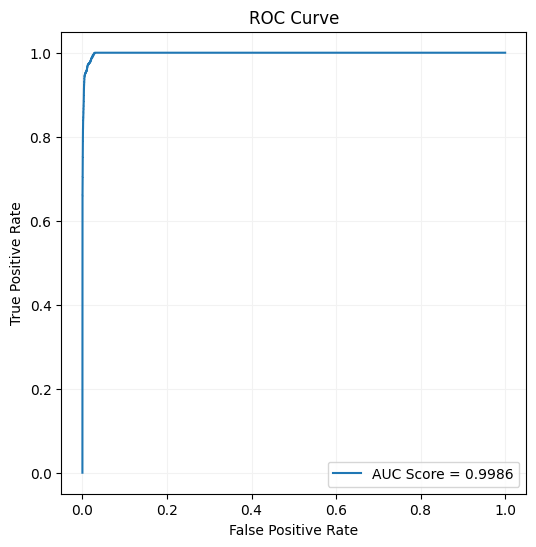

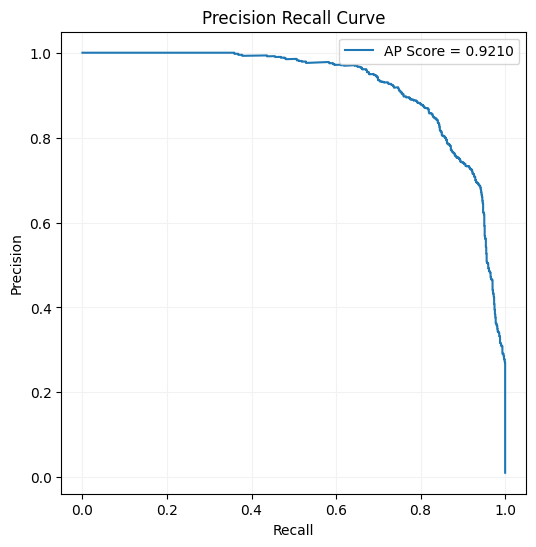

In [17]:
t = mp.Tester(model, model_device, test_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5));
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6));
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

# Conclusion

Our very rudimentary custom attention mechanism seems to have had a slight beneficial impact on the **AUC-score** of the model, but it did worse in terms of **F1**. The worse F1-score is due to the higher False Positive count. Due to the extra attention layer this model has more parameters than the previous examples, so this might not be a fair comparison.

We need to be careful drawing conclusions because of the data and the fact the series are short. Attention was desinged to help models with long series. The real proof would be to increase the series to 50 or more and then compare results, ideally on very realistic data. Normally we'd expect to see bigger benefits from attention as the length of the series increases.